# Accumulated Local Effects (ALE) Plots

ALE plots are a tool used in machine learning to understand the relationship between features and the model's predictions. They visualize the effect of a feature on the predicted outcome while accounting for interactions with other features.

For more information on ALE plots, visit the official documentation: [Interpretable Machine Learning - ALE](https://christophm.github.io/interpretable-ml-book/ale.html)

## Why Use ALE Plots?

- Gain insights into how individual features influence the model's predictions.
- Identify and understand feature interactions.
- Improve model interpretability and trustworthiness.
- Detect potential issues or biases in the model.

By analyzing ALE plots, data scientists and machine learning practitioners can make more informed decisions about feature engineering, model selection, and model refinement.

text generated by AI :)


In [ ]:
import pandas as pd
import os
import pickle 
import joblib
from PyALE import ale
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import xgboost as xgb


# Load saved model

In [4]:
model_dir = "../models/saved_model_20250306_202811"  # Replace with the actual saved folder name
model_path = os.path.join(model_dir, "best_xgb_model.xgb")
model_xgbc = xgb.XGBClassifier()
model_xgbc.load_model(model_path) 

# Load data used to train the model

In [5]:
df = pd.read_csv('../data/preprocessed_data/train_data.csv')

id_cols = ['gameId',	'playId',	'nflId_tackler']
target_variables = ['tackle|max', 'assist|max', 'pff_missedTackle|max', 'tackle_success']
target_variable = 'tackle_success'

X = df.drop(columns=id_cols + target_variables)
y = df[target_variable]

training_columns=model_xgbc.feature_names_in_


# Calculate feature importance gain

In [6]:
importance = model_xgbc.get_booster().get_score(importance_type='gain')
sortedfi = dict(sorted(importance.items(),key=lambda item: item[1], reverse=True))
importance_df = pd.DataFrame.from_dict(sortedfi, orient='index', columns=['gain']).reset_index()

# Merge in one dataframe the features and the importance
i = 0
features_dict = pd.DataFrame(columns=['f', 'name'])
for feature in training_columns:
    new_row = pd.DataFrame({'f': ['f' + str(i)], 'name': [feature]})  # Create a DataFrame
    features_dict = pd.concat([features_dict, new_row], ignore_index=True)  # Use concat instead of append
    i += 1

merged = pd.merge(importance_df, features_dict, how="left", left_on="index", right_on="name").sort_values(by=['gain'], ascending=False)

In [7]:
merged.head(20)

,index,gain,f,name
0,dis_tackler|min,33.225048,f20,dis_tackler|min
1,position_ballcarrier|mode_QB,9.759940,f124,position_ballcarrier|mode_QB
2,ballcarrier_x_range,6.855537,f118,ballcarrier_x_range
3,dir_range_tackler,6.797221,f117,dir_range_tackler
4,y_tackler|max,4.301492,f6,y_tackler|max
5,s_tackler|mean,4.290246,f12,s_tackler|mean
6,x_ballcarrier|max,4.220610,f81,x_ballcarrier|max
7,a_tackler|mean,4.161834,f17,a_tackler|mean
8,position_tackler|mode_DE,4.160707,f130,position_tackler|mode_DE
9,dis_tackler|mean,4.077792,f22,dis_tackler|mean


### Here we will give explanation only on the most influential feature,  **tackle_success**. 

## Overview and how to look at ALE plots
This ALE plot visualizes how the feature **"dis_tackler|min"** (minimum distance traveled from the prior frame in yards) influences **tackle_success**

- **X-axis (dis_tackler|min):** Minimum distance traveled by the tackler in a given gameplay.
- **Y-axis (Effect on Prediction, Centered):** The impact of "dis_tackler|min" on tackle success probability.
- **Black Dots & Line:** ALE values, showing the average marginal effect of different values of "dis_tackler|min."
- **Error Bars:** Variability in effect estimates.
- **Light Blue Histogram (Right Y-axis - Size):** Distribution of "dis_tackler|min" values in the dataset.

## Observations
1. **Flat Regions (Near 0 Effect):** At low values of "dis_tackler|min" (~0 to ~0.08), the effect on tackle success is minimal.
2. **Negative Effect (~0.09 to ~0.1):** A slight dip in ALE values suggests that tackles made when the minimum distance traveled is around these values may have a reduced probability of success.
3. **Sharp Positive Effect (~0.1 to ~0.16):** The model predicts a significant increase in tackle success probability as the minimum distance increases in this range.
4. **Stable High Effect (~0.16+):** The ALE values stabilize, indicating that once a tackler covers a minimum distance of approximately 0.16 yards or more, any further movement has no additional impact on tackle success

## Takeaways
- **Optimal Movement Range:** Tacklers who move at least **~0.16 yards** in a frame may have a higher probability of successful tackles.
- **Error Bars & Variance:** The increasing variance suggests variability in tackle success when movement is high (~0.16+ yards), possibly due to other unaccounted factors (e.g., defensive positioning, opponent movement).


## Next steps
- **Other features analysis**
- **2D plot to copmare with other characteristics**

<Figure size 2400x600 with 0 Axes>

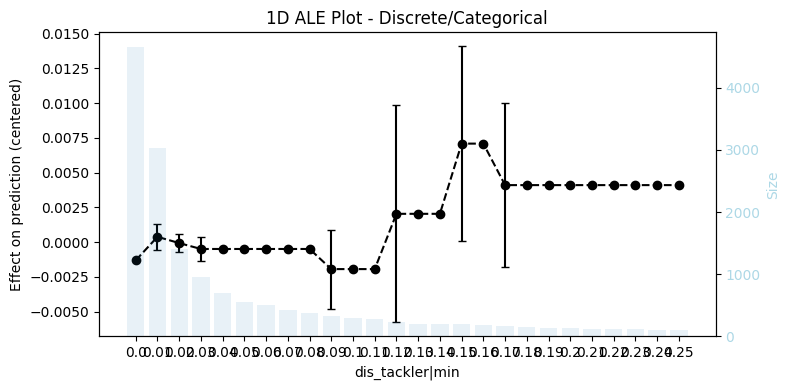

In [23]:
feature = 'dis_tackler|min'

# Feature is very skewed, so we need to remove outliers

Q1 = X[feature].quantile(0.25)
Q3 = X[feature].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the data to remove outliers
filtered_df = X[(X[feature] >= lower_bound) & (X[feature] <= upper_bound)]
filtered_df.head()

plt.figure(figsize=(24, 6)) 
# Generate ALE plot
ale_eff = ale(
    X=filtered_df, 
    model=model_xgbc, 
    feature=[feature], 
    feature_type="discrete", 
    include_CI=True
)

plt.show()


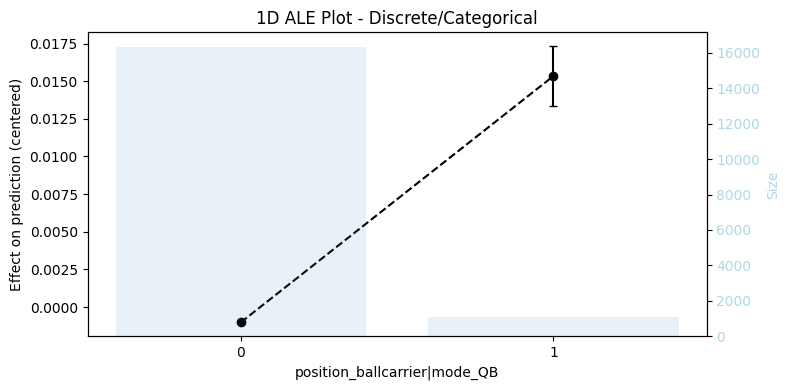

In [40]:
feature = 'position_ballcarrier|mode_QB'

ale_eff = ale(
    X=X, model=model_xgbc, feature=[feature], 
    feature_type ="discrete", include_CI=True,
)

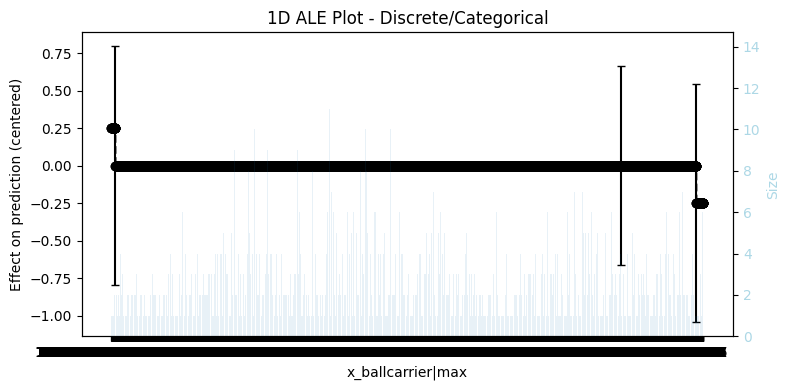

In [42]:
feature = 'x_ballcarrier|max'

ale_eff = ale(
    X=X, model=model_xgbc, feature=[feature], 
    feature_type ="discrete", include_CI=True,
)


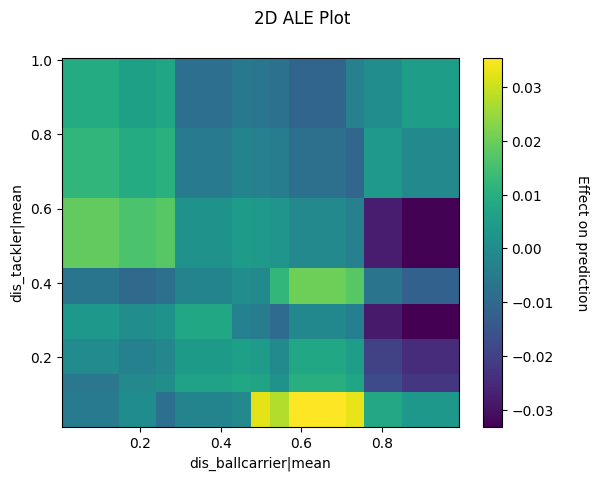

In [14]:
feature1, feature2 = 'dis_tackler|mean', 'dis_ballcarrier|mean'
ale_eff = ale(
    X=X, model=model_xgbc, feature=[feature1, feature2], 
    feature_type ="discrete", include_CI=True,
)